In [2]:
import numpy as np
import seaborn as sns
from stochastic_processes import StochasticProcess, StochasticIntegration, SdeSolver, Functionmaker

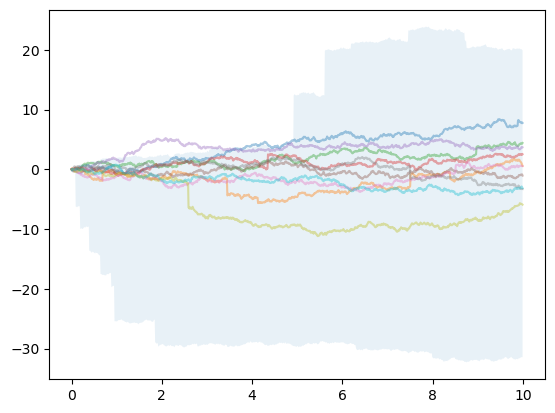

In [7]:
process = StochasticProcess(time=10, timestep=0.01, number=100, poisson_rate=10, shape=1, scale=1)
t, Xt = process.levyprocess()
process.plot_solution(t, Xt, with_mean=False, with_var=False, num_max=10)

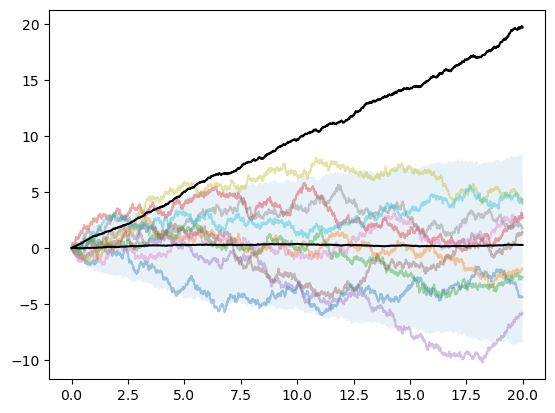

In [10]:
process = StochasticProcess(time=20, timestep=0.01, number=500, poisson_rate=6, shape=1, scale=1)
t, Xt = process.brownianmotion()
process.plot_solution(t, Xt, with_mean=True, with_var=True, num_max=10)    

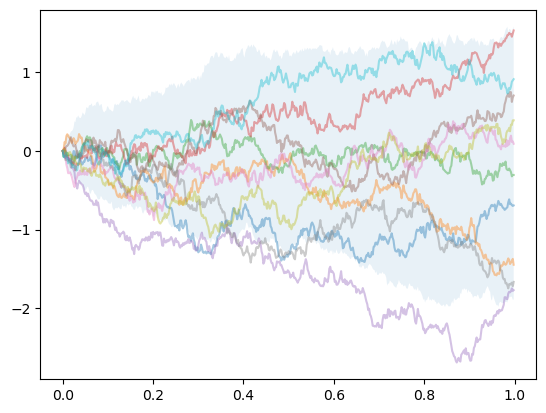

In [11]:
# from stochastic_processes import StochasticProcess
process = StochasticProcess(time=1, timestep=0.002, number=100, poisson_rate=6, shape=1, scale=1)
t, Xt = process.brownianmotion()
process.plot_solution(t, Xt, num_max=10)
# mean_stop, var_stop = process.stoppingstatistics(Xt, t, tau=1) # Mean is about half. Should be 1.
# print(mean_stop, var_stop)

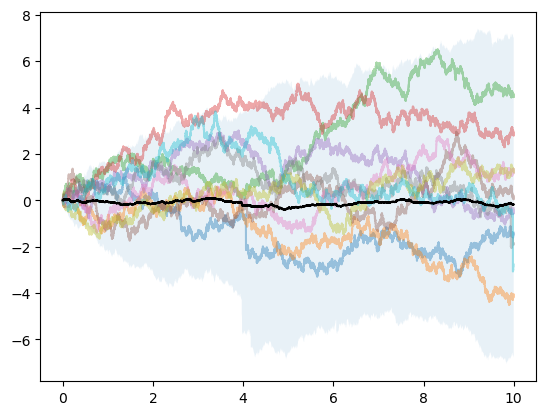

(1.0484900000000001, 0.6136222548999999)

In [14]:
# from stochastic_processes import StochasticProcess
process = StochasticProcess(time=10, timestep=0.0005, number=100, poisson_rate=25, shape=0.5, scale=1)
t, Xt = process.levyprocess()

process.plot_solution(t, Xt, with_mean=True, num_max=10)
process.stoppingstatistics(Xt, t, tau=1)

c:\Users\gouwenss\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

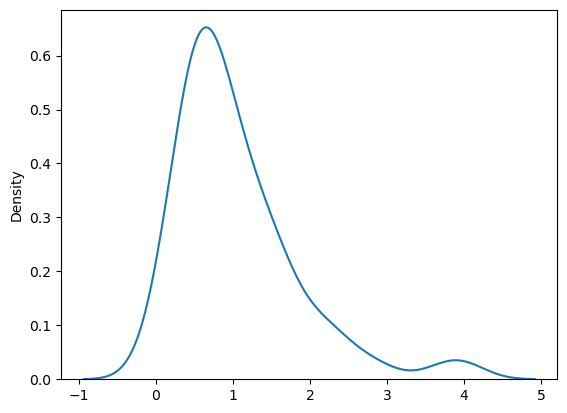

In [15]:
stopping_indices = process.findstoppingindices(Xt, tau=1)
stopping_times = t[stopping_indices]

sns.kdeplot(stopping_times)

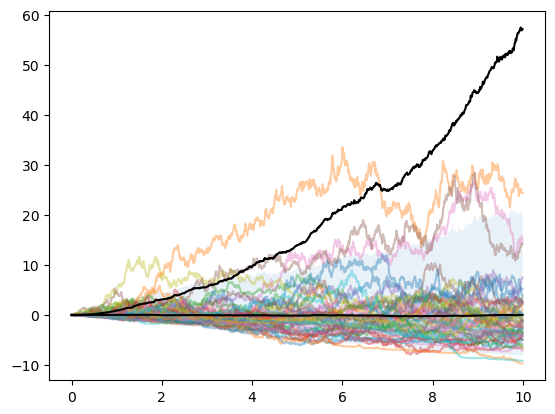

In [16]:
f_function = lambda t, x: np.sin(t) + x

integrate = StochasticIntegration(time=10, timestep=0.01, number=1000, shape=1, scale=0.1, integrator="brownianmotion")
t, Xt = integrate.stochastic_integral(fun=integrate.f_func)
integrate.plot_solution(t, Xt, num_max=50, with_mean=True, with_var=True)

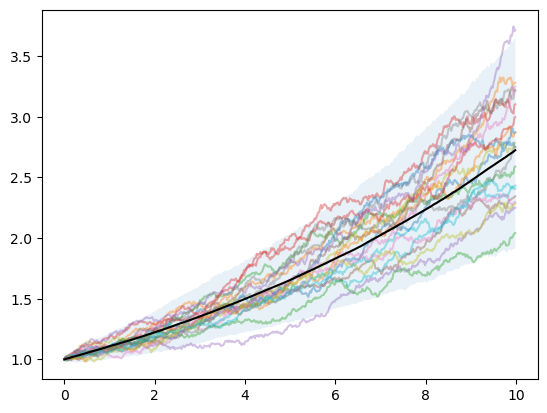

0.3167953693602123 0.09829280438032044


In [20]:
sdesolve = SdeSolver(time=10, timestep=0.02, number=1000, poisson_rate=10, shape=.2, scale=2, integrator="brownianmotion")

t, Xt = sdesolve.solve_sde(f_func=sdesolve.f_blackscholes, g_func=sdesolve.g_blackscholes, value_init=1)
sdesolve.plot_solution(t, Xt, with_mean=True, with_var=False)

returns = sdesolve.european_option(t, Xt, call_time=9, strike_price=2.2)

print(np.mean(returns), np.var(returns))

In [21]:
# Do thest this. add a function f and g such that the parameters give prettier results.
sdesolve = SdeSolver(time=10, timestep=0.02, number=2500, poisson_rate=4, shape=1, scale=1, integrator="brownianmotion")
t, Xt = sdesolve.solve_sde(value_init=1)

sdesolve.plot_solution(t, Xt, with_mean=True, with_var=False)

TypeError: SdeSolver.solve_sde() missing 2 required positional arguments: 'f_func' and 'g_func'

In [22]:
alpha = 1.1
beta = 0.7
delta = 1
gamma = 0.5
sigma1 = 0.01
sigma2 = 0.01

f_funs = Functionmaker().generate_linears(part_x=[alpha, 0],  part_y=[0, -gamma], part_x_y=[-beta, delta])
g_funs = Functionmaker().generate_linears(part_x=[sigma1, 0], part_y=[0, sigma2])

In the next, we create use Functionmaker to generate the function used in the Lotka Volterra SDE. Note that in normal literature, this is a normal system of differential equations, but a small adjustment turns it into a system of stochastic differential equations. The original is given by:

$$\frac{dx}{dt}=\alpha x(t)- \beta x(t)y(t)$$
$$\frac{dx}{dt}=\delta x(t)y(t)- \gamma y(t)$$

Rewrite into differential form, and add noise that is proportional to the population size yields

$$dX_t = (\alpha X_t - \beta X_tY_t)dt + \sigma_1X_tdB_t$$
$$dY_t = (\delta X_tY_t - \gamma Y_t)dt + \sigma_2Y_tdB_t$$

If $y(t)$ is constant in the upper line, it closely resembles the Black-Scholes equation, but more in an ecological context. In our simulation we choose the values:


$\alpha=X, \beta=X, \delta=X, \gamma=X$

The Funtionmaker.generate_linears method makes a list of functions of the type 
$$f(t, x) = c_0 + c_1t + c_3x + c_4y + c_5xy.$$
This relates to SDE's as they are written in the general form
$$dX_t = f(t, X_t)dt + g(t, X_t)dB_t$$

In [25]:
sdesolve = SdeSolver(time=50, timestep=0.01, number=25, poisson_rate=4, shape=1, scale=1, integrator="brownianmotion")

t, Mt = sdesolve.integrator()
_, M2t = sdesolve.integrator()

dMt = np.hstack((np.diff(Mt), np.zeros((Mt.shape[0], 1)))) 
dM2t = np.hstack((np.diff(Mt), np.zeros((Mt.shape[0], 1)))) 

Xt = np.full_like(Mt, fill_value=1) 
Yt = np.full_like(Mt, fill_value=1) 

for i in range(1, Mt.shape[1]):
    Xt[:,i] = Xt[:,i-1] + f_funs[0](t[i-1], Xt[:,i-1], Yt[:,i-1])*sdesolve.timestep + g_funs[0](t[i-1], Xt[:,i-1], Yt[:,i-1])*dMt[:,i]
    Yt[:,i] = Yt[:,i-1] + f_funs[1](t[i-1], Xt[:,i-1], Yt[:,i-1])*sdesolve.timestep + g_funs[1](t[i-1], Xt[:,i-1], Yt[:,i-1])*dMt[:,i]

# sdesolve.plot_solution(t, Xt, color="black", alpha=.2)

In [35]:
Mt = 

array([[1.        , 1.0030096 , 1.00609631, ..., 0.10220124, 0.1020232 ,
        0.10178917],
       [1.        , 1.00598958, 1.01018774, ..., 0.14518273, 0.14536231,
        0.14563045]])

In [ ]:
sdesolve = SdeSolver(time=10, timestep=0.02, number=2500, poisson_rate=4, shape=1, scale=1, integrator="brownianmotion")
t, Xt = sdesolve.solve_sde_system(value_init=1) # this function may not work for multidimensional results. 

sdesolve.plot_solution(t, Xt, with_mean=True, with_var=False) # this function may not work for multidimensional results. 